In [9]:
%pylab inline

from __future__ import division # the python 3 division - outputs double instead of am int
from __future__ import print_function # the python 3 print function - print()
from tqdm import tqdm # library add a progrees bar for an iterating for loops

from explauto.environment import environments # library environment for modeling implementation


import time,datetime # librraies to keep track of times
import threading  # library for multithreading workloads

import os    #
import wave  # library for recording sound and exporting as a wave file
import alsaaudio, audioop, sys  # library for recording sound


import numpy as np # python's standard linear algebra library: needed for static arrays
import pandas as pd    #
import matplotlib.pyplot as plt # library for graphing data
from matplotlib.pyplot import specgram
from scipy.io import wavfile
import torch as th    # a python version of Lua's Torch ML library.

from poppy.creatures import PoppyRattle
poppy = PoppyRattle()    # creates poppy object. For physical robot 
# poppy = PoppyRattle(simulator='vrep')    # creates poppy object. For simulated robot. vrep scene needs work

# for loop primes the motors to be programmed
for m in poppy.motors:
    m.compliant = False
    #m.goto_behavior = 'minjerk' # prevents jerky movements

# Python (array) lists to store feedback data

# for physical robot
pos = []
# for simulator
pos_Head = []    # Stores the position of the hand (wrist) relative to the head
pos_Stand = []    # Stores the position of the hand (wrist) relative to the center point between the feet
TIME = []    # Stores timestamps of when the arm is in a certain position
sys_load = []    # Stores the torque the motors are going through at a point in time.
                 # Good for being warry of the system load of a task and possibly calculating fatigue
speed = []    # Stores the angle speed the motors are travelling at
temp = []   # Stores the motors' temperature
volt = []   # Stores the motor's voltage. 
            # In conjunction with Temperaure, this can be used to measure energy of a task

# specific arrays for the rattle shaking movement
data_table = []  # stores the sound features of a recording
spike = [[],[]]  # stores instances of abnormal spikes in sound features and a given timestamp


# activate microphone - A Logitech C920 webcam
inp = alsaaudio.PCM(alsaaudio.PCM_CAPTURE,alsaaudio.PCM_NONBLOCK,device='sysdefault:CARD=C920')
inp.setchannels(2)
inp.setrate(88200)
inp.setformat(alsaaudio.PCM_FORMAT_GSM)
inp.setperiodsize(160)

wavDir = "../in_Data/{}".format(datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d'))
if not os.path.exists(wavDir):
    os.makedirs(wavDir)
csvDir = "../out_Data/csv/{}".format(datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d'))
if not os.path.exists(csvDir):
    os.makedirs(csvDir)
pngDir = "../out_Data/png/{}".format(datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d'))
if not os.path.exists(pngDir):
    os.makedirs(pngDir)

Populating the interactive namespace from numpy and matplotlib


In [30]:
#w = wave.open("../in_Data/2017-02-21/13:00:51_rattle.wav",'r')
# Open the device in nonblocking capture mode. The last argument could
    # just as well have been zero for blocking mode. Then we could have
    # left out the sleep call in the bottomvim of the loop

sampFreq, snd = wavfile.read("../in_Data/2017-02-21/13:00:51_rattle.wav")
one,oneD =wavfile.read("../in_Data/2017-02-21/13:07:31_rattle.wav")
two,twoD =wavfile.read("../in_Data/2017-02-21/13:39:03_rattle.wav")
rat,rattle = wavfile.read("../in_Data/rattleAlone/rattleAlone_0.wav")

In [3]:
temp = w.readframes(w.getnframes())


In [12]:
print(type(snd))
print(len(snd))


<type 'numpy.ndarray'>
493850


/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:7222: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


(array([[  1.37674047e+03,   3.76233042e+02,   0.00000000e+00, ...,
           1.41151596e-01,   6.64062500e-01,   2.43775313e+02],
        [  1.82631547e+03,   6.28062523e+02,   0.00000000e+00, ...,
           1.39697199e+00,   3.35934688e-01,   9.25629811e+02],
        [  1.70963345e+03,   3.48505648e+02,   0.00000000e+00, ...,
           3.73837162e-01,   2.31689449e-06,   1.51865059e+03],
        ..., 
        [  6.07480611e-01,   7.92155750e-01,   0.00000000e+00, ...,
           2.80111498e-03,   2.83792698e-16,   1.40665960e+01],
        [  9.74401593e+00,   1.16044662e+00,   0.00000000e+00, ...,
           2.79997355e-03,   7.08947489e-17,   1.17026707e+01],
        [  2.17524828e-01,   6.55398683e-01,   0.00000000e+00, ...,
           1.39979944e-03,   2.06238145e-33,   4.80875380e+00]]),
 array([   0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
           9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,
          18.,   19.,   20.,   21.,   22.,   23., 

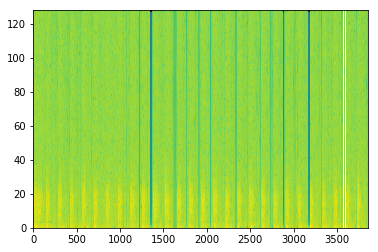

In [13]:

specgram(snd.flatten(), NFFT=256, Fs=256)

(array([[  4.45831881e+02,   2.15959159e+03,   1.47659708e+04, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  1.30523946e+03,   5.99759979e+03,   1.81153841e+04, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  5.03865614e+02,   3.83735626e+03,   2.96460241e+03, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        ..., 
        [  1.78921428e+00,   1.02751884e+01,   1.95738349e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  2.78113496e+00,   3.58732873e+00,   4.64147054e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  3.21091770e+00,   8.82197302e-01,   1.03010787e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00]]),
 array([   0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
           9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,
          18.,   19.,   20.,   21.,   22.,   23., 

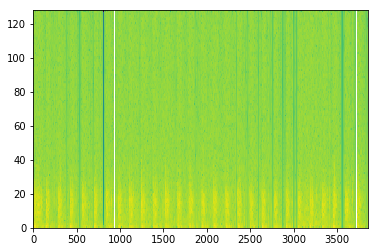

In [28]:
specgram(oneD.flatten(), NFFT=256, Fs=256)

(array([[  1.66000965e+01,   8.60852306e+03,   4.40822477e+01, ...,
           6.77106499e+02,   3.49955702e-03,   9.46403404e+02],
        [  3.87537418e+01,   1.27068063e+04,   3.72233764e+02, ...,
           1.25400460e+03,   4.51543955e+00,   2.11263973e+03],
        [  3.67904347e+01,   3.26715156e+03,   7.03012301e+02, ...,
           9.70683672e+02,   5.54852692e+00,   2.39937782e+03],
        ..., 
        [  3.11419268e-02,   2.19207228e+00,   3.03106316e-01, ...,
           3.05735039e+00,   1.30703165e-03,   2.76894227e+00],
        [  3.92736114e-01,   2.95891952e+01,   6.85912429e-01, ...,
           4.34873265e+00,   1.76465760e-02,   4.95211811e-01],
        [  4.99129625e-01,   2.89151955e+01,   5.76999551e-01, ...,
           2.47121050e+00,   1.46648306e-02,   1.84738940e-02]]),
 array([   0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
           9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,
          18.,   19.,   20.,   21.,   22.,   23., 

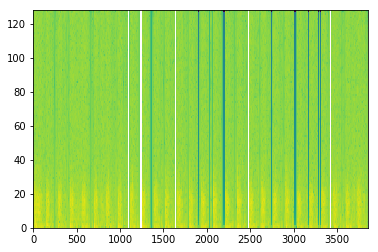

In [32]:
specgram(twoD.flatten(), NFFT=256, Fs=256)

(array([[  1.20356158e-05,   8.85187794e-06,   7.53084471e-07, ...,
           3.46770612e-05,   6.84391045e-06,   1.16164682e-08],
        [  1.12734871e-05,   6.82277600e-06,   1.59794139e-06, ...,
           2.11198385e-05,   2.63275883e-06,   4.04624796e-06],
        [  5.14360095e-07,   2.00519125e-06,   1.42413084e-07, ...,
           2.42058754e-07,   1.93907179e-07,   1.18194122e-06],
        ..., 
        [  2.50959586e-11,   7.05126642e-10,   6.77998469e-11, ...,
           3.31681050e-11,   3.30482036e-11,   3.51272690e-10],
        [  9.80277912e-08,   1.32535377e-07,   1.13038344e-07, ...,
           6.17562955e-11,   6.91654934e-11,   5.70023469e-10],
        [  2.08500412e-07,   2.40192482e-07,   2.26225155e-07, ...,
           5.35780555e-11,   4.84820294e-11,   3.06878865e-10]]),
 array([   0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
           9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,
          18.,   19.,   20.,   21.,   22.,   23., 

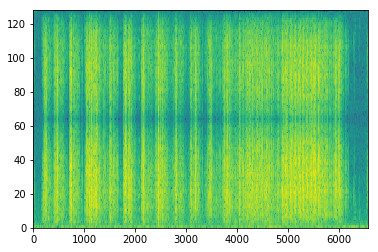

In [33]:
specgram(rattle.flatten(), NFFT=256, Fs=256)

In [34]:
# RUN at the end of working

pos = []
pos_Head = []
pos_Stand = []
TIME = []
sys_load = []
speed = []
temp = []
volt = []
data_table = []
spike = [[],[]]
for m in poppy.motors:
    m.compliant = True
time.sleep(1)
poppy.stop_sync()
poppy.close()